In [53]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
from sklearn.model_selection import train_test_split
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/celiasagastume/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [54]:
#load data
data = pd.read_csv("./jigsaw-toxic-severity-rating/validation_data.csv")

In [55]:
#create distinct df's for more toxic and less toxic comments

less_toxic = data.drop('more_toxic', axis=1)
more_toxic = data.drop('less_toxic', axis =1)

#add target column to both 

less_toxic['target'] = 0
more_toxic['target'] = 1

#rename text column for both 

less_toxic = less_toxic.rename(columns={'less_toxic':'text'})
more_toxic = more_toxic.rename(columns={'more_toxic':'text'})

#rejoin data 

comments = pd.concat([less_toxic, more_toxic], axis =0)

#randomly reorder

comments = comments.sample(frac=1).reset_index(drop=True)

#create average target score for comments 
comments = comments.groupby('text')['target'].mean().reset_index()

#shape
print(comments.head())

#save comments

comments.to_csv("comments.csv", index=False)

                                                text    target
0  \n\nThe comment directly above this one are fr...  0.666667
1  \n\nwhy should people have to read crap posted...  0.888889
2      \nGo F yourself you cottonheadednittymuggins.  0.666667
3  \nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...  0.000000
4   \n\n koreans claim  \n\ni see youve seen the ...  0.333333


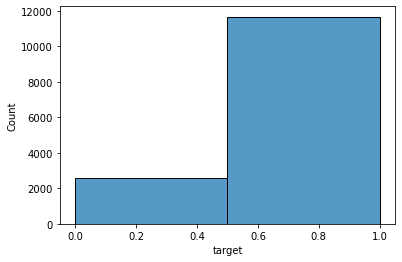

In [56]:
# #remap target values 

comments['target'] = (comments['target'] > 0.0) * 1

#histogram of toxic values per comment 
%matplotlib inline
sns.histplot(data=comments, x="target", binwidth=.5)
plt.show()


In [57]:
#create text clean + tokenizer function

punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~__'
words = set(nltk.corpus.words.words())
stop = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
cv_tfidf = TfidfVectorizer(preprocessor=' '.join)





def to_token(text):
    
    
    text = [text.translate(str.maketrans('', '', string.punctuation))]
    text = [word_tokenize(word) for word in text]
    text = [item for sublist in text for item in sublist]
    text = [stemmer.stem(word) for word in text]
    text = [re.sub(r'http\S+', '', each) for each in text]
    text = [re.sub('[0-9+]', '', each) for each in text]
    text = [re.sub('_', '', each) for each in text]
    text = [re.sub("\n","",each) for each in text]
    text = [re.sub('/_/g', '', each) for each in text]
    text = [re.sub('[^\u0000-\u05C0\u2100-\u214F]+', '', each) for each in text]
    text = [re.sub('[\u0401\u0451\u0410-\u044f]', '', each) for each in text]
    text = [word for word in text if word not in stop]
    text = [word.lower() for word in text]
    text = ["".join(dict.fromkeys(word)) for word in text]

    

    return text

In [58]:
#split data into X and y

X, y = comments['text'], comments['target']
print(X.shape, y.shape)



(14251,) (14251,)


In [59]:
#partition data into test data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)


In [60]:
#create series of all unique comments in the dataset

train_corpus = [word for word in X_train]
test_corpus = [word for word in X_test]


# #tokenize train and test sets 

train_features = [to_token(comment) for comment in train_corpus]
test_features = [to_token(comment) for comment in test_corpus]

In [61]:
#create tfidf vector matrix for train and test sets 
tfidf = TfidfVectorizer(preprocessor=' '.join)

train_tfidf = tfidf.fit_transform(train_features)
test_tfidf = tfidf.transform(test_features)




In [62]:
#use truncated SVD on each tfidf matrix
svd = TruncatedSVD(n_components=25, random_state=33)

train_svd = svd.fit_transform(train_tfidf)
test_svd = svd.transform(test_tfidf)



In [63]:
#scale features

scale=StandardScaler()
X_train_scaled = scale.fit_transform(train_svd)
X_test_scaled = scale.transform(test_svd)



In [64]:
#check for distribution of labels
y_train.value_counts(normalize=True)

1    0.817807
0    0.182193
Name: target, dtype: float64

In [65]:
#create base model
lr_basemodel =LogisticRegression()

In [66]:
# train base model
lr_basemodel.fit(X_train_scaled,y_train)
y_pred_basemodel = lr_basemodel.predict(X_test_scaled)

In [67]:
#get base f1 and roc auc score for model
print("f1 score for base model is : " , f1_score(y_test,y_pred_basemodel))
print("ROC AUC score for base model is : ", roc_auc_score(y_test, y_pred_basemodel))

f1 score for base model is :  0.9040200038468936
ROC AUC score for base model is :  0.5009545579069927


In [68]:
#Hyperparameter tuning
# define model/create instance
lr=LogisticRegression()
#tuning weight for minority class then weight for majority class will be 1-weight of minority class
#Setting the range for class weights
weights = np.linspace(0.0,0.99,500)
#specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1,10,15,20], 'penalty': [ 'l2'],"class_weight":[{0:x ,1:1.0 -x} for x in weights]}
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
#Gridsearch for hyperparam tuning
model= GridSearchCV(estimator= lr,param_grid=param,scoring="roc_auc",cv=folds,return_train_score=True)
#train model to learn relationships between x and y
model.fit(X_train_scaled,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.0019839679358717435,
                                           1: 0.9980160320641283},
                                          {0: 0.003967935871743487,
                                           1: 0.9960320641282565},
                                          {0: 0.0059519038076152305,
                                           1: 0.9940480961923848},
                                          {0: 0.007935871743486974,
                                           1: 0.99206412825...
                                           1: 0.9543687374749499},
                                          {0: 0.047615230460921844,
                                           1: 0.9523847695390781},
                      

In [69]:
# print best hyperparameters
print("Best ROC AUC score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best ROC AUC score:  0.6437623593420919
Best hyperparameters:  {'C': 20, 'class_weight': {0: 0.43845691382765534, 1: 0.5615430861723447}, 'penalty': 'l2'}


In [70]:
#Build Model with best params
lr2=LogisticRegression(class_weight={0: 0.6963727454909819, 1: 0.30362725450901806}
                       ,C=10,penalty="l2")
lr2.fit(X_train_scaled,y_train)

LogisticRegression(C=10,
                   class_weight={0: 0.6963727454909819, 1: 0.30362725450901806})

In [71]:
# predict probabilities on Test and take probability for class 1([:1])
y_pred_prob_test = lr2.predict_proba(X_test_scaled)[:, 1]
#predict labels on test dataset
y_pred_test = lr2.predict(X_test_scaled)
# create onfusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(f"confusion Matrix is : \n\n", cm)
print(f"\n")

# ROC- AUC score
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test,y_pred_prob_test))
#Precision score
print("precision score  test dataset:  ", precision_score(y_test,y_pred_test))
#Recall Score
print("Recall score  test dataset:  ", recall_score(y_test,y_pred_test))
#f1 score
print("f1 score  test dataset :  ", f1_score(y_test,y_pred_test))

confusion Matrix is : 

 [[  42  454]
 [  84 2271]]


ROC-AUC score  test dataset:   0.6428643586055749
precision score  test dataset:   0.833394495412844
Recall score  test dataset:   0.9643312101910828
f1 score  test dataset :   0.8940944881889764


In [72]:
X_test = pd.DataFrame(X_test)
X_test.head()

,text
2245,Stefano \nIt would be a much better world if ...
6577,"""\nThey might seem silly to you, but try watch..."
5141,"""\n\nI am the person who made the page about ""..."
2758,Women Preachers \n\nWhy do so called Christia...
4618,"""\n\n Your Lie(s) About Me \n\nYou wrote:\n""""F..."


In [73]:
#create toxic probability output df
test_output = X_test.copy()
test_output['target'] = y_test.tolist()
test_output["model_probability"] = y_pred_prob_test.tolist()
test_output['prediction'] = y_pred_test.tolist()


#create toxic probability output for comments that are mislabeled 1
miss_0 =  test_output.loc[(test_output['target'] == 0) & (test_output['model_probability']>0.50)]
miss_0.head()

,text,target,model_probability,prediction
9143,He's notable alright as being a friggen racist...,0,0.641854,1
4222,"""\n\n Nonsense sentence \n\n""""The internationa...",0,0.594551,1
9579,"I didn't say you favored him over me, I said y...",0,0.623038,1
2911,You just make me laugh \n\nHAHAHAHAHAHA so yo...,0,0.826627,1
11398,Silly isn't she? Leabian girl. And you see she...,0,0.683888,1


In [74]:
#create toxic probability output for comments that are mislabeled 0
miss_1 =  test_output.loc[(test_output['target'] == 1) & (test_output['model_probability']<0.50)]
miss_1.head()

,text,target,model_probability,prediction
4291,"""\n\n Please stop your disruptive editing. If ...",1,0.266958,0
11538,Stop vandalizing the Byrchall High School page...,1,0.428810,0
12117,Vandalizing ==\n\nStop undoing things,1,0.467711,0
2537,Vandalism? \nI have traced this IP \nhttp://e...,1,0.474485,0
7144,"""== Vandalism ==\n\n{{subst:uw-vandalism3|Pres...",1,0.495347,0


In [75]:
#save probability score df

test_output.to_csv("lr_output.csv")

In [76]:
 lr2.coef_.T

array([[ 0.16983402],
       [ 0.80003777],
       [-0.11897215],
       [ 0.19579705],
       [ 0.35809865],
       [ 0.07623292],
       [ 0.01236455],
       [-0.06943656],
       [-0.04039331],
       [-0.17824921],
       [-0.13196447],
       [ 0.16098943],
       [-0.00094102],
       [ 0.09072981],
       [-0.00603638],
       [ 0.07799175],
       [ 0.0391595 ],
       [ 0.07885244],
       [-0.06261115],
       [ 0.08092859],
       [ 0.11838693],
       [-0.06565282],
       [ 0.04632651],
       [-0.0262095 ],
       [ 0.0554791 ]])

In [82]:
miss_1.iloc[3,0]

' Vandalism? \nI have traced this IP \nhttp://en.wikipedia.org/wiki/User_talk:78.55.58.71 but I had not found the slightest hint on vandalism. Why do you block users on false reasons?  92.230.85.188  '

In [86]:
miss_0.iloc[3,0]

' You just make me laugh \n\nHAHAHAHAHAHA so you are some aussie bitch hiding behind a computer and changing what i write, im half abo half lebo so i am the truth u cannot face but your girlfriend faces every night ;)'